In [1]:
# Cell 1 — Imports & Model Loading
import os
from config import IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNEL, OUTPUT_CHANNEL, HIDDEN_SIZE, NUM_FIDUCIAL, CHARACTERS, MAX_LABEL_LENGTH
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataset import LmdbDataset, AlignCollate
from utils import CTCLabelConverter, Averager
from model import CRNN
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# device & paths
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEST_LMDB    = "v4_lmdb_data_!/test"
MODEL_PATH   = "trained_model/best_ctc_crnn_!_6939.pth"

# build converter & model
converter   = CTCLabelConverter(CHARACTERS)
num_classes = len(converter.character)
model = CRNN(
    IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNEL,
    OUTPUT_CHANNEL, HIDDEN_SIZE, num_classes,
    False, NUM_FIDUCIAL
).to(device)

# load weights & set eval
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# loss
criterion = nn.CTCLoss(blank=0, zero_infinity=True).to(device)

In [2]:
# put this near the top of the notebook
SEP_TOKEN = '!'                       # the newline marker we want to ignore
def strip_sep(s: str) -> str:
    """Return s with the separator removed (GT or prediction)."""
    return s.replace(SEP_TOKEN, '')

In [3]:
# Cell 2 — Test‐loader & evaluation function
import numpy as np  # ensure numpy is imported

# prepare test DataLoader
collate_fn  = AlignCollate(imgH=IMG_HEIGHT, imgW=IMG_WIDTH, keep_ratio_with_pad=False)
test_ds     = LmdbDataset(TEST_LMDB)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False,
    num_workers=0, collate_fn=collate_fn, pin_memory=True
)

def evaluate_ctc(model, loader, max_len=MAX_LABEL_LENGTH):
    model.eval()
    avg_loss = Averager()
    total_samples = 0
    correct_samples = 0
    total_chars = 0
    correct_chars = 0
    all_confs = []

    with torch.no_grad():
        for images, texts in loader:
            images = images.to(device)
            # 1) encode targets → (targets, target_lengths)
            targets, target_lengths = converter.encode(
                texts, batch_max_length=max_len
            )

            # 2) forward → [B, T, C]
            logits = model(images)

            # 3) log‐softmax + permute → [T, B, C]
            log_probs = logits.log_softmax(2).permute(1, 0, 2)

            # 4) input_length = T for every sample
            B, T, _ = logits.size()
            input_lengths = torch.full(
                (B,), T, dtype=torch.long, device=device
            )

            # 5) CTC loss
            loss = criterion(
                log_probs,
                targets,
                input_lengths,
                target_lengths
            )
            avg_loss.add(loss)

            # 6) greedy CTC decode over the full T
            probs            = logits.softmax(2)    # [B, T, C]
            max_vals, max_inds = probs.max(2)      # both [B, T]
            inds_np          = max_inds.cpu().numpy()
            full_lens        = np.full((B,), T, dtype=int)
            pred_strs        = converter.decode(inds_np, full_lens)

            # 7) accumulate sample– and char–level stats
            total_samples  += B
            correct_samples += sum(p == g for p, g in zip(pred_strs, texts))

            for gt, pr, conf_seq in zip(texts, pred_strs, max_vals):
                # character‐level
                total_chars += len(gt)
                correct_chars += sum(
                    1 for i, ch in enumerate(gt)
                    if i < len(pr) and pr[i] == ch
                )
                # per‐sample mean confidence
                all_confs.append(conf_seq.mean().item())

    sample_acc = correct_samples / total_samples * 100
    char_acc   = correct_chars   / total_chars   * 100
    return avg_loss.val(), sample_acc, char_acc, all_confs

# ─── run evaluation ───────────────────────────────────────────────────────────
test_loss, sample_acc, char_acc, confidences = evaluate_ctc(model, test_loader)
print(f"CTC Test loss: {test_loss:.4f}")
print(f"Sample-level acc: {sample_acc:.2f}%")
print(f"Char-level   acc: {char_acc:.2f}%")


Loaded 315 valid samples from v4_lmdb_data_!/test
CTC Test loss: 0.7070
Sample-level acc: 59.05%
Char-level   acc: 84.31%


Metric      Value
0      Test Loss   0.706971
1  Test Accuracy  59.047619

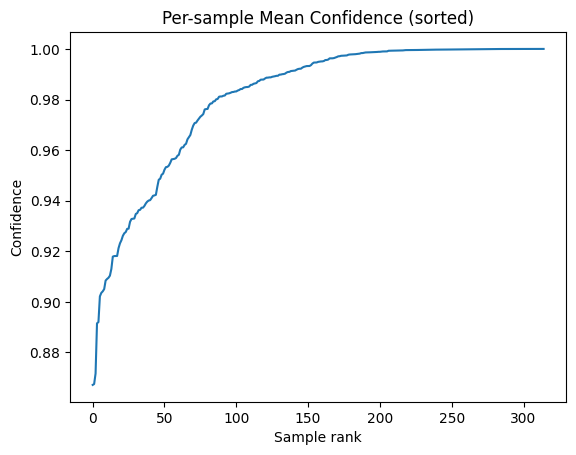

In [4]:
# Cell 3 — Summary table & line‐plot of confidences over samples
# 1) summary table
test_loss_val = test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss

df = pd.DataFrame({
    'Metric': ['Test Loss', 'Test Accuracy'],
    'Value' : [test_loss_val, sample_acc]
})
display(df)

# 2) plot confidences (sorted) to see distribution
sorted_confs = sorted(confidences)
plt.figure()
plt.plot(sorted_confs)
plt.title("Per-sample Mean Confidence (sorted)")
plt.xlabel("Sample rank")
plt.ylabel("Confidence")
plt.show()

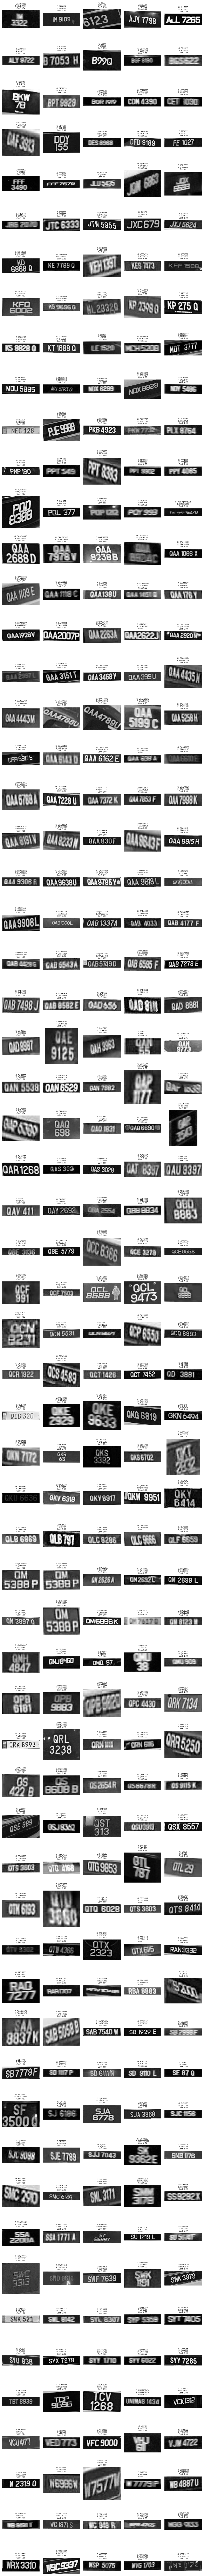

In [5]:
# Cell 4 — Visualize test examples (CTC)
import math
import numpy as np
import matplotlib.pyplot as plt

n    = len(test_ds)
cols = 5
rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
axes = axes.flatten()

# turn off any extra axes
for ax in axes[n:]:
    ax.axis('off')

for idx in range(n):
    img, gt = test_ds[idx]
    ax = axes[idx]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

    # make a batch of size 1
    image_batch, _ = collate_fn([(img, gt)])
    image_batch = image_batch.to(device)

    # 1) forward through CTC‐only model → [1, T, C]
    logits = model(image_batch)

    # 2) get per‐time‐step probs and best indices
    probs          = logits.softmax(2)      # [1, T, C]
    max_vals, max_inds = probs.max(2)      # both [1, T]

    # 3) collapse via your CTCLabelConverter.decode
    inds_np  = max_inds.cpu().numpy()      # shape (1, T)
    T        = inds_np.shape[1]
    pred_str = converter.decode(inds_np, [T])[0]  # removes blanks/repeats

    # average confidence across time steps
    conf = float(max_vals.mean())

    ax.set_title(f"G: {gt}\nP: {pred_str}\nConf: {conf:.2f}", fontsize=6)

plt.tight_layout()
plt.show()


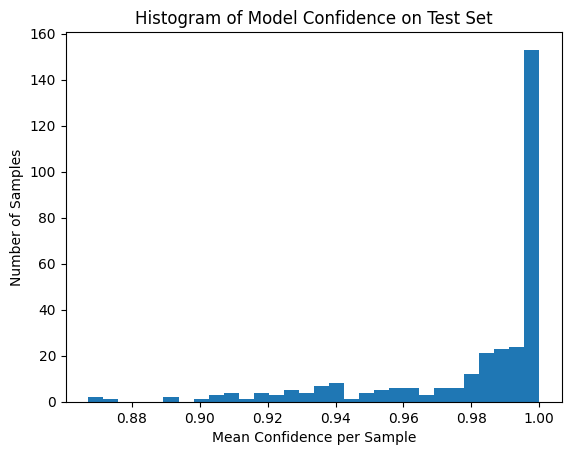

In [6]:
# Cell 5 — Histogram of confidences
plt.figure()
plt.hist(confidences, bins=30)
plt.title("Histogram of Model Confidence on Test Set")
plt.xlabel("Mean Confidence per Sample")
plt.ylabel("Number of Samples")
plt.show()
